Group assignment: Second-level & ROI analysis
===

Dataset: *Entorhinal grid-like codes and time-locked network dynamics track others navigating through space (Wagner et al., 2022)*

# 0. Setup

## Imports

In [2]:
from nipype import config
import os
from os.path import join as opj, abspath
import numpy as np
import pandas as pd
from nilearn import datasets, plotting, image
from pprint import pprint
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns

template = datasets.load_mni152_template(resolution=1)

config.update_config(
    {
        "logging": {"workflow_level": "INFO"},
        "execution": {
            "stop_on_first_crash": "True",
            "hash_method": "content",
            "remove_unnecessary_outputs": "True",
        },
    }
)

contrast_dir_dict = {
    "navigation > baseline * cumulative distance error (vm)": "navigation",
    "obervation > baseline * cumulative distance error (vm)": "other",
    "observation > navigation": "other-self",
    "?": "self",
    "navigation > observation": "self-other",
}

# Check if ENV variables are set
print("'FSLDIR':", os.environ["FSLDIR"])
print("'FSLOUTPUTTYPE':", os.environ["FSLOUTPUTTYPE"])

fslpath = os.environ["FSLDIR"]

'FSLDIR': /opt/fsl-5.0.11
'FSLOUTPUTTYPE': NIFTI


## Download data

In [27]:
data_dir = "data_Wagner_NatComms_2022"
data_url = "https://ucloud.univie.ac.at/index.php/s/lxNhTQJ4TbkaLnh/download"

if os.path.exists(data_dir) == False:
    print("Downloading data ...", end="")
    import requests
    from zipfile import ZipFile

    r = requests.get(data_url)
    open("data.zip", "wb").write(r.content)
    print("completed.")
    print("Unzipping data ...", end="")
    with ZipFile("data.zip", "r") as zo:
        zo.extractall()
    zo.close()
    print("completed.")
    print("Removing zipfile ...", end="")
    os.remove("data.zip")
    print("completed.")

else:
    print("Data already downloaded.")

Unzipping data ...completed.
Removing zipfile ...completed.


# Second-level analysis

## **A**) Model for `other > self`

### Define data and distance matrix

In [28]:
chosen_contrast = "observation > navigation"


cmaps_dir = (
    data_dir
    + "/model_m1_contrasts_swratopup/"
    + contrast_dir_dict[chosen_contrast]
    + "-AllSessions"
)

print(f"data is stored in: {abspath(cmaps_dir)}")

cmaps = sorted(
    glob(
        f"{abspath(cmaps_dir)}/**/*.nii",
        recursive=True,
    )
)

# pprint(cmaps)
print(f"\nThere are {len(cmaps)} contrast maps")

n_subjects = len(cmaps)
subject_list = [f"sub-{i:02d}" for i in range(1, n_subjects + 1)]

# Intercept-only model, no groups, no 2nd level contrasts
design_matrix = pd.DataFrame(
    [1] * n_subjects, columns=["intercept"], index=subject_list
)

design_matrix.head()

data is stored in: /main/assignments/group/data_Wagner_NatComms_2022/model_m1_contrasts_swratopup/other-self-AllSessions

There are 59 contrast maps


,intercept
sub-01,1
sub-02,1
sub-03,1
sub-04,1
sub-05,1


In [30]:
from nilearn.glm.second_level import SecondLevelModel

second_level = SecondLevelModel(n_jobs=2)
second_level = second_level.fit(cmaps, design_matrix=design_matrix)

other_self = second_level.compute_contrast(
    second_level_contrast="intercept", output_type="stat", second_level_stat_type="t"
)

## Correcting multiple comparisons

<div class="alert alert-warning">Do we need the complete image with all the negative activations for calculating the threshold?</div>

### Thresholded map

In [31]:
from nilearn.glm import threshold_stats_img
from nilearn.image import resample_to_img


thresholded_map, threshold = threshold_stats_img(
    other_self, alpha=0.001, height_control="fdr", cluster_threshold=91, two_sided=True
)

print(f"The FDR=.001 threshold is {round(threshold, 3)}")


thresholded_map_pos = image.new_img_like(
    thresholded_map, np.clip(thresholded_map.get_fdata(), 0, None)
)

# scale up resolution to template
thresholded_map_pos = resample_to_img(thresholded_map_pos, template)

The FDR=.001 threshold is 3.541


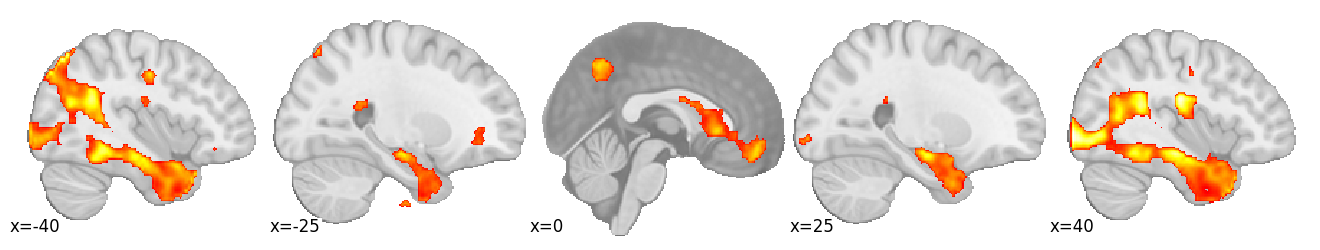

In [32]:
plotting.plot_stat_map(
    thresholded_map_pos,
    bg_img=template,
    cut_coords=(-40, -25, 0, 25, 40),
    display_mode="x",
    threshold=threshold,
    vmax=10,
    black_bg=False,
    colorbar=False,
)

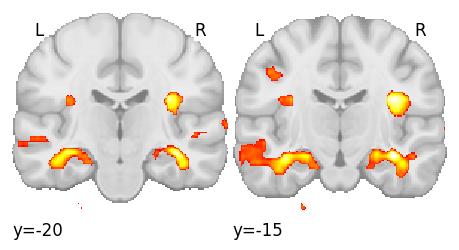

In [33]:
plotting.plot_stat_map(
    thresholded_map_pos,
    bg_img=template,
    cut_coords=(-20, -15),
    display_mode="y",
    threshold=threshold,
    vmax=10,
    black_bg=False,
    colorbar=False,
)

## Surface plots

In [34]:
from nilearn import surface
from nilearn import datasets

# for higher resolution
big_fsaverage = datasets.fetch_surf_fsaverage("fsaverage")
big_texture_r = surface.vol_to_surf(thresholded_map_pos, big_fsaverage.pial_right)
big_texture_l = surface.vol_to_surf(thresholded_map_pos, big_fsaverage.pial_left)


Dataset created in /root/nilearn_data/fsaverage



Downloaded 26173440 of 28905506 bytes (90.5%,    0.2s remaining) ...done. (4 seconds, 0 min)
Extracting data from /root/nilearn_data/fsaverage/5592d63c5c8039b4f902396c128dcd85/download..... done.


### Multiple views

with higher resolution (`surf_mesh` argument)

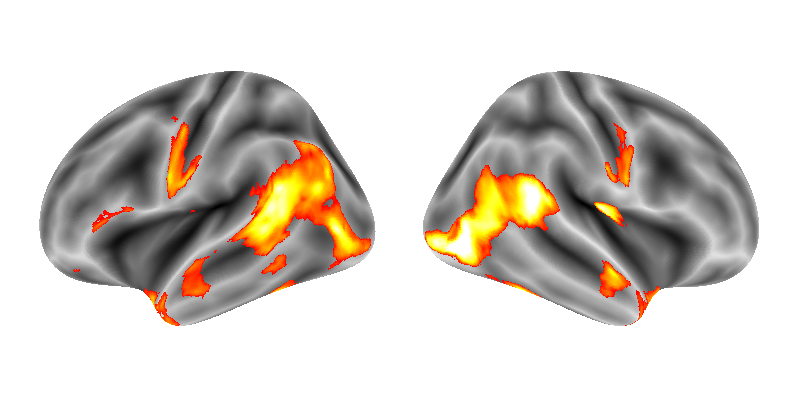

In [35]:
plotting.plot_img_on_surf(
    thresholded_map_pos,
    surf_mesh=big_fsaverage,
    views=["lateral"],
    hemispheres=["left", "right"],
    threshold=threshold,
    colorbar=False,
    inflate=True,
    vmax=10,
)
plotting.show()

## Multiplot figure

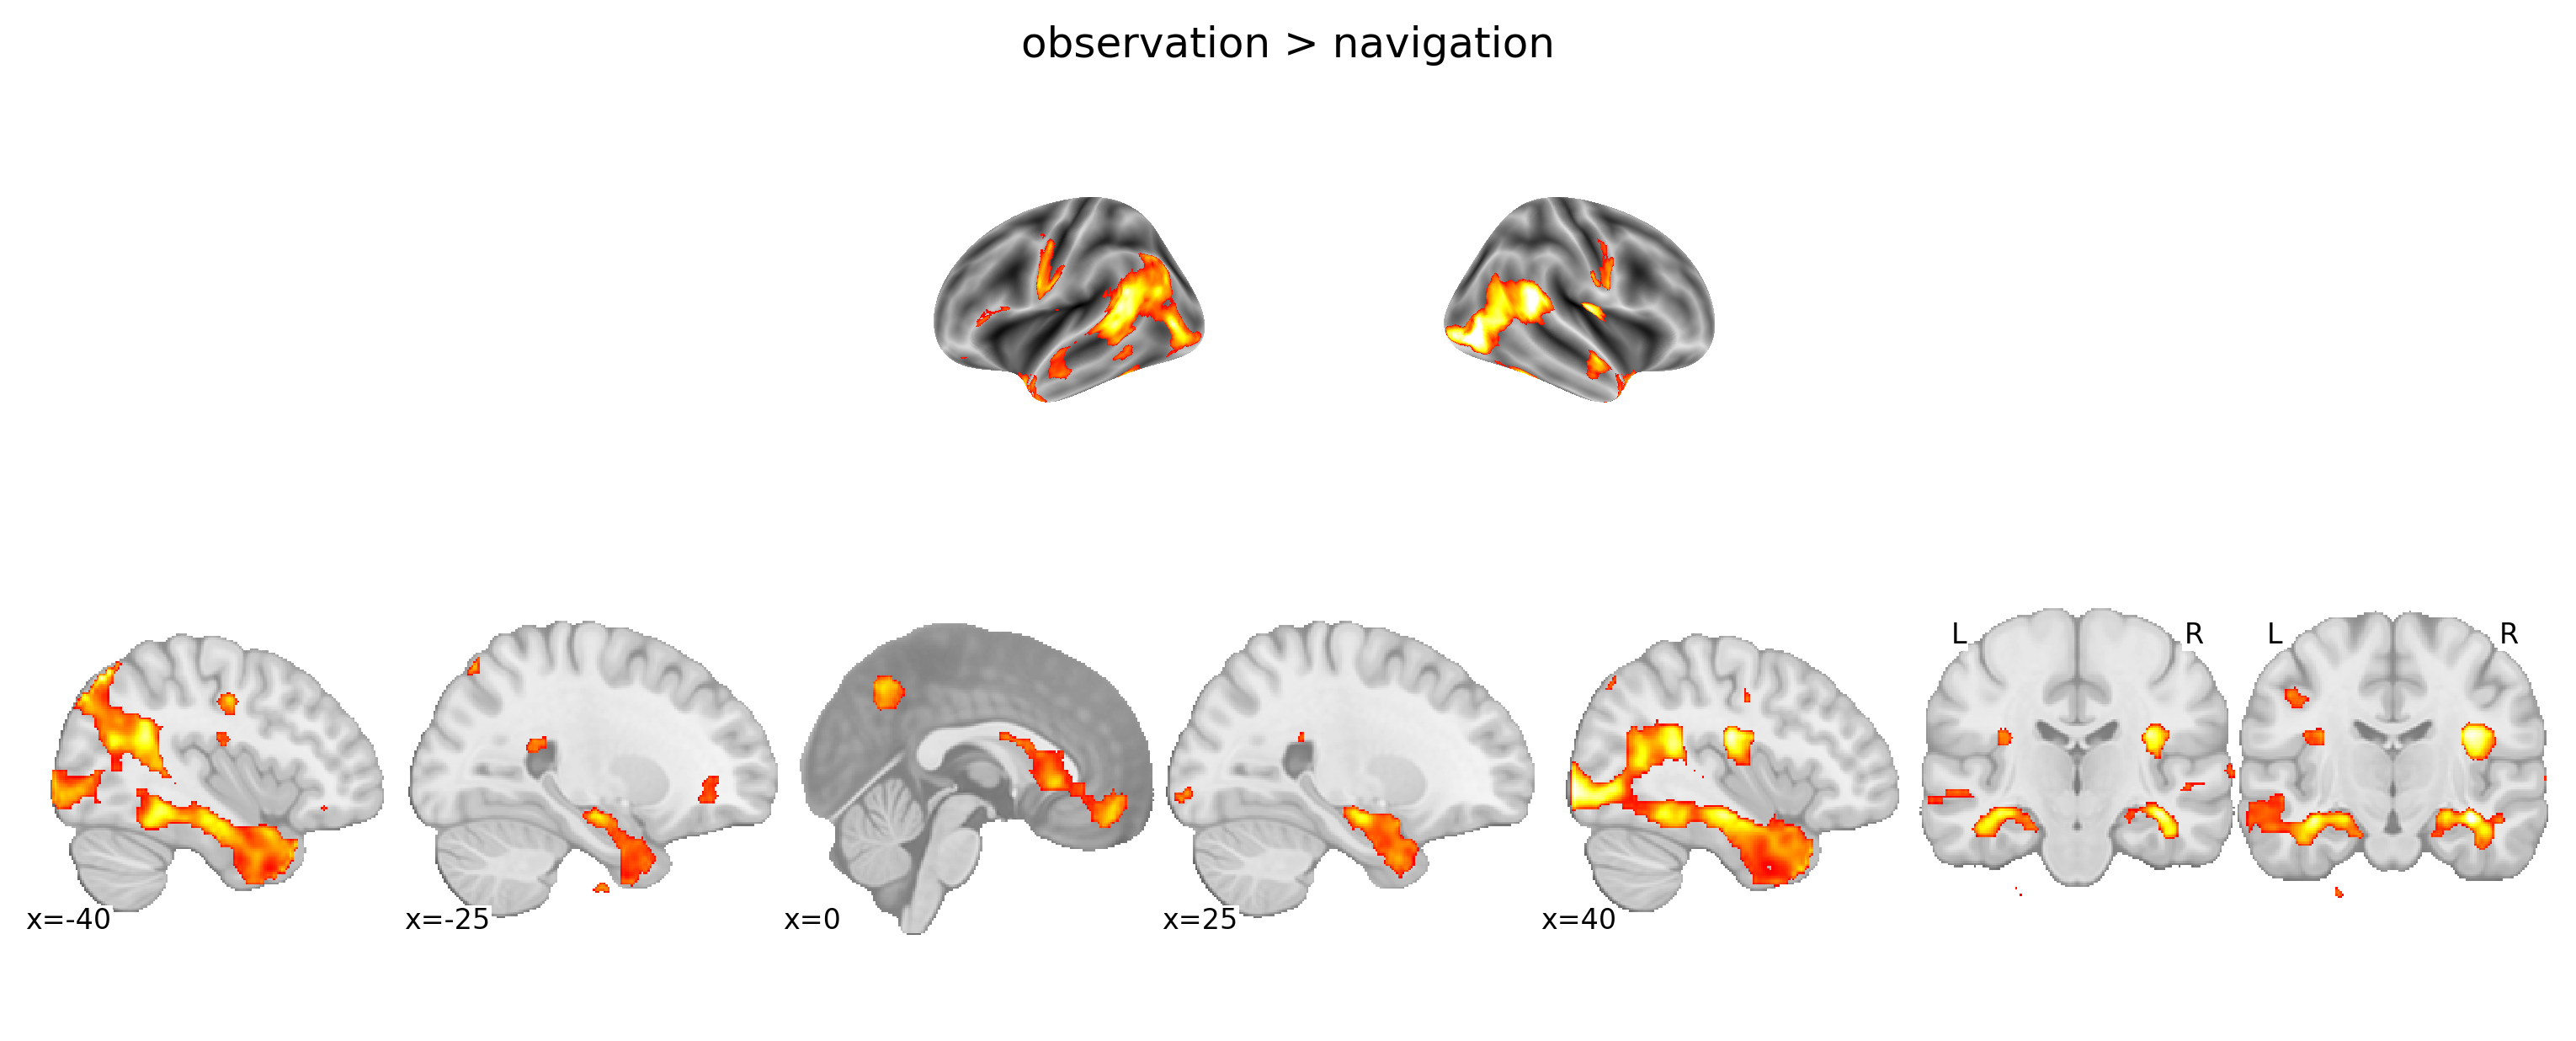

In [36]:
fig = plt.figure(figsize=(10, 4), dpi=300)
#  rc('font', size=8)

plot_upper_l = fig.add_subplot(2, 4, 2, projection="3d")

plotting.plot_surf_stat_map(
    big_fsaverage.infl_left,
    big_texture_l,
    hemi="left",
    view="lateral",
    colorbar=False,
    threshold=threshold,
    bg_map=big_fsaverage.sulc_left,
    vmax=10,
    figure=fig,
    axes=plot_upper_l,
)


plot_upper_r = fig.add_subplot(2, 4, 3, projection="3d")
plotting.plot_surf_stat_map(
    big_fsaverage.infl_right,
    big_texture_r,
    hemi="right",
    view="lateral",
    colorbar=False,
    threshold=threshold,
    bg_map=big_fsaverage.sulc_right,
    vmax=10,
    figure=fig,
    axes=plot_upper_r,
)


plot_left = plotting.plot_stat_map(
    thresholded_map_pos,
    bg_img=template,
    cut_coords=(-40, -25, 0, 25, 40),
    display_mode="x",
    threshold=threshold,
    vmax=10,
    black_bg=False,
    colorbar=False,
    annotate=False,
    figure=fig,
    axes=(0, 0, 0.75, 0.48),  # axes = (xmin, ymin, width, height)
)

plot_left.annotate(left_right=False, positions=True, size=8, scale_loc="center")

plot_right = plotting.plot_stat_map(
    thresholded_map_pos,
    bg_img=template,
    cut_coords=(-20, -15),
    display_mode="y",
    threshold=threshold,
    vmax=10,
    black_bg=False,
    colorbar=False,
    annotate=False,
    figure=fig,
    axes=(0.75, 0, 0.25, 0.48),
)

plot_right.annotate(left_right=True, positions=False, size=8, scale_loc="center")

fig.suptitle(chosen_contrast)

fig.savefig(f"multiplot_figure_obs_nav.png")

## **B**) Model for `self > other`

### Define data and distance matrix

In [37]:
chosen_contrast = "navigation > observation"


cmaps_dir = (
    data_dir
    + "/model_m1_contrasts_swratopup/"
    + contrast_dir_dict[chosen_contrast]
    + "-AllSessions"
)

print(f"data is stored in: {abspath(cmaps_dir)}")

cmaps = sorted(
    glob(
        f"{abspath(cmaps_dir)}/**/*.nii",
        recursive=True,
    )
)

# pprint(cmaps)
print(f"\nThere are {len(cmaps)} contrast maps")

n_subjects = len(cmaps)
subject_list = [f"sub-{i:02d}" for i in range(1, n_subjects + 1)]

# Intercept-only model, no groups, no 2nd level contrasts
design_matrix = pd.DataFrame(
    [1] * n_subjects, columns=["intercept"], index=subject_list
)

design_matrix.head()

data is stored in: /main/assignments/group/data_Wagner_NatComms_2022/model_m1_contrasts_swratopup/self-other-AllSessions

There are 59 contrast maps


,intercept
sub-01,1
sub-02,1
sub-03,1
sub-04,1
sub-05,1


In [38]:
from nilearn.glm.second_level import SecondLevelModel

second_level = SecondLevelModel(n_jobs=2)
second_level = second_level.fit(cmaps, design_matrix=design_matrix)

other_self = second_level.compute_contrast(
    second_level_contrast="intercept", output_type="stat", second_level_stat_type="t"
)

## Correcting multiple comparisons

<div class="alert alert-warning">Do we need the complete image with all the negative activations for calculating the threshold?</div>

### Thresholded map

In [52]:
from nilearn.glm import threshold_stats_img
from nilearn.image import resample_to_img


thresholded_map, threshold = threshold_stats_img(
    other_self, alpha=0.001, height_control="fdr", cluster_threshold=91, two_sided=True
)

print(f"The FDR=.001 threshold is {round(threshold, 3)}")


thresholded_map_pos = image.new_img_like(
    thresholded_map, np.clip(thresholded_map.get_fdata(), 0, None)
)

# scale up resolution to template
thresholded_map_pos = resample_to_img(thresholded_map_pos, template)

The FDR=.001 threshold is 3.541


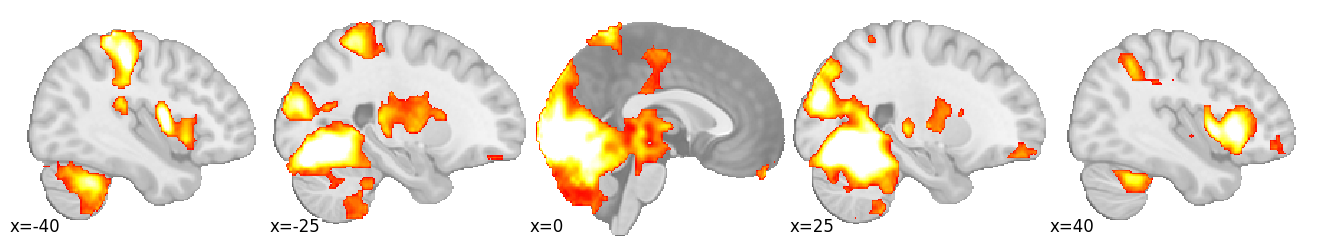

In [53]:
plotting.plot_stat_map(
    thresholded_map_pos,
    bg_img=template,
    cut_coords=(-40, -25, 0, 25, 40),
    display_mode="x",
    threshold=threshold,
    vmax=10,
    black_bg=False,
    colorbar=False,
)

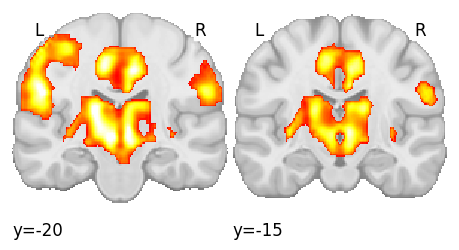

In [54]:
plotting.plot_stat_map(
    thresholded_map_pos,
    bg_img=template,
    cut_coords=(-20, -15),
    display_mode="y",
    threshold=threshold,
    vmax=10,
    black_bg=False,
    colorbar=False,
)

## Surface plots

In [55]:
from nilearn import surface
from nilearn import datasets

# for higher resolution
big_fsaverage = datasets.fetch_surf_fsaverage("fsaverage")
big_texture_r = surface.vol_to_surf(thresholded_map_pos, big_fsaverage.pial_right)
big_texture_l = surface.vol_to_surf(thresholded_map_pos, big_fsaverage.pial_left)

### Multiple views

with higher resolution (`surf_mesh` argument)

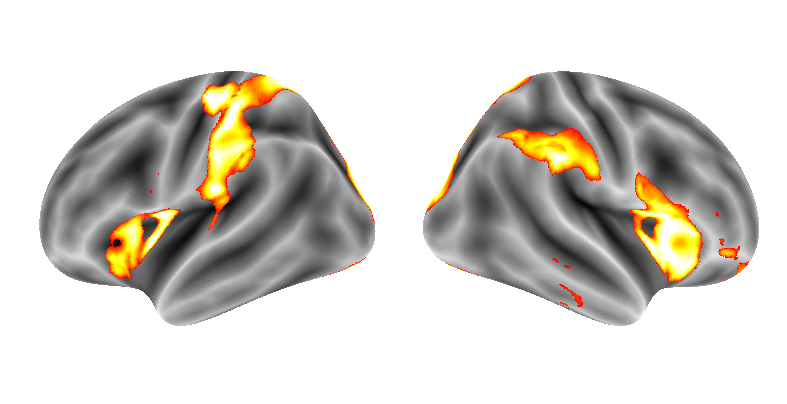

In [56]:
plotting.plot_img_on_surf(
    thresholded_map_pos,
    surf_mesh=big_fsaverage,
    views=["lateral"],
    hemispheres=["left", "right"],
    threshold=threshold,
    colorbar=False,
    inflate=True,
    vmax=10,
)
plotting.show()

## Multiplot figure

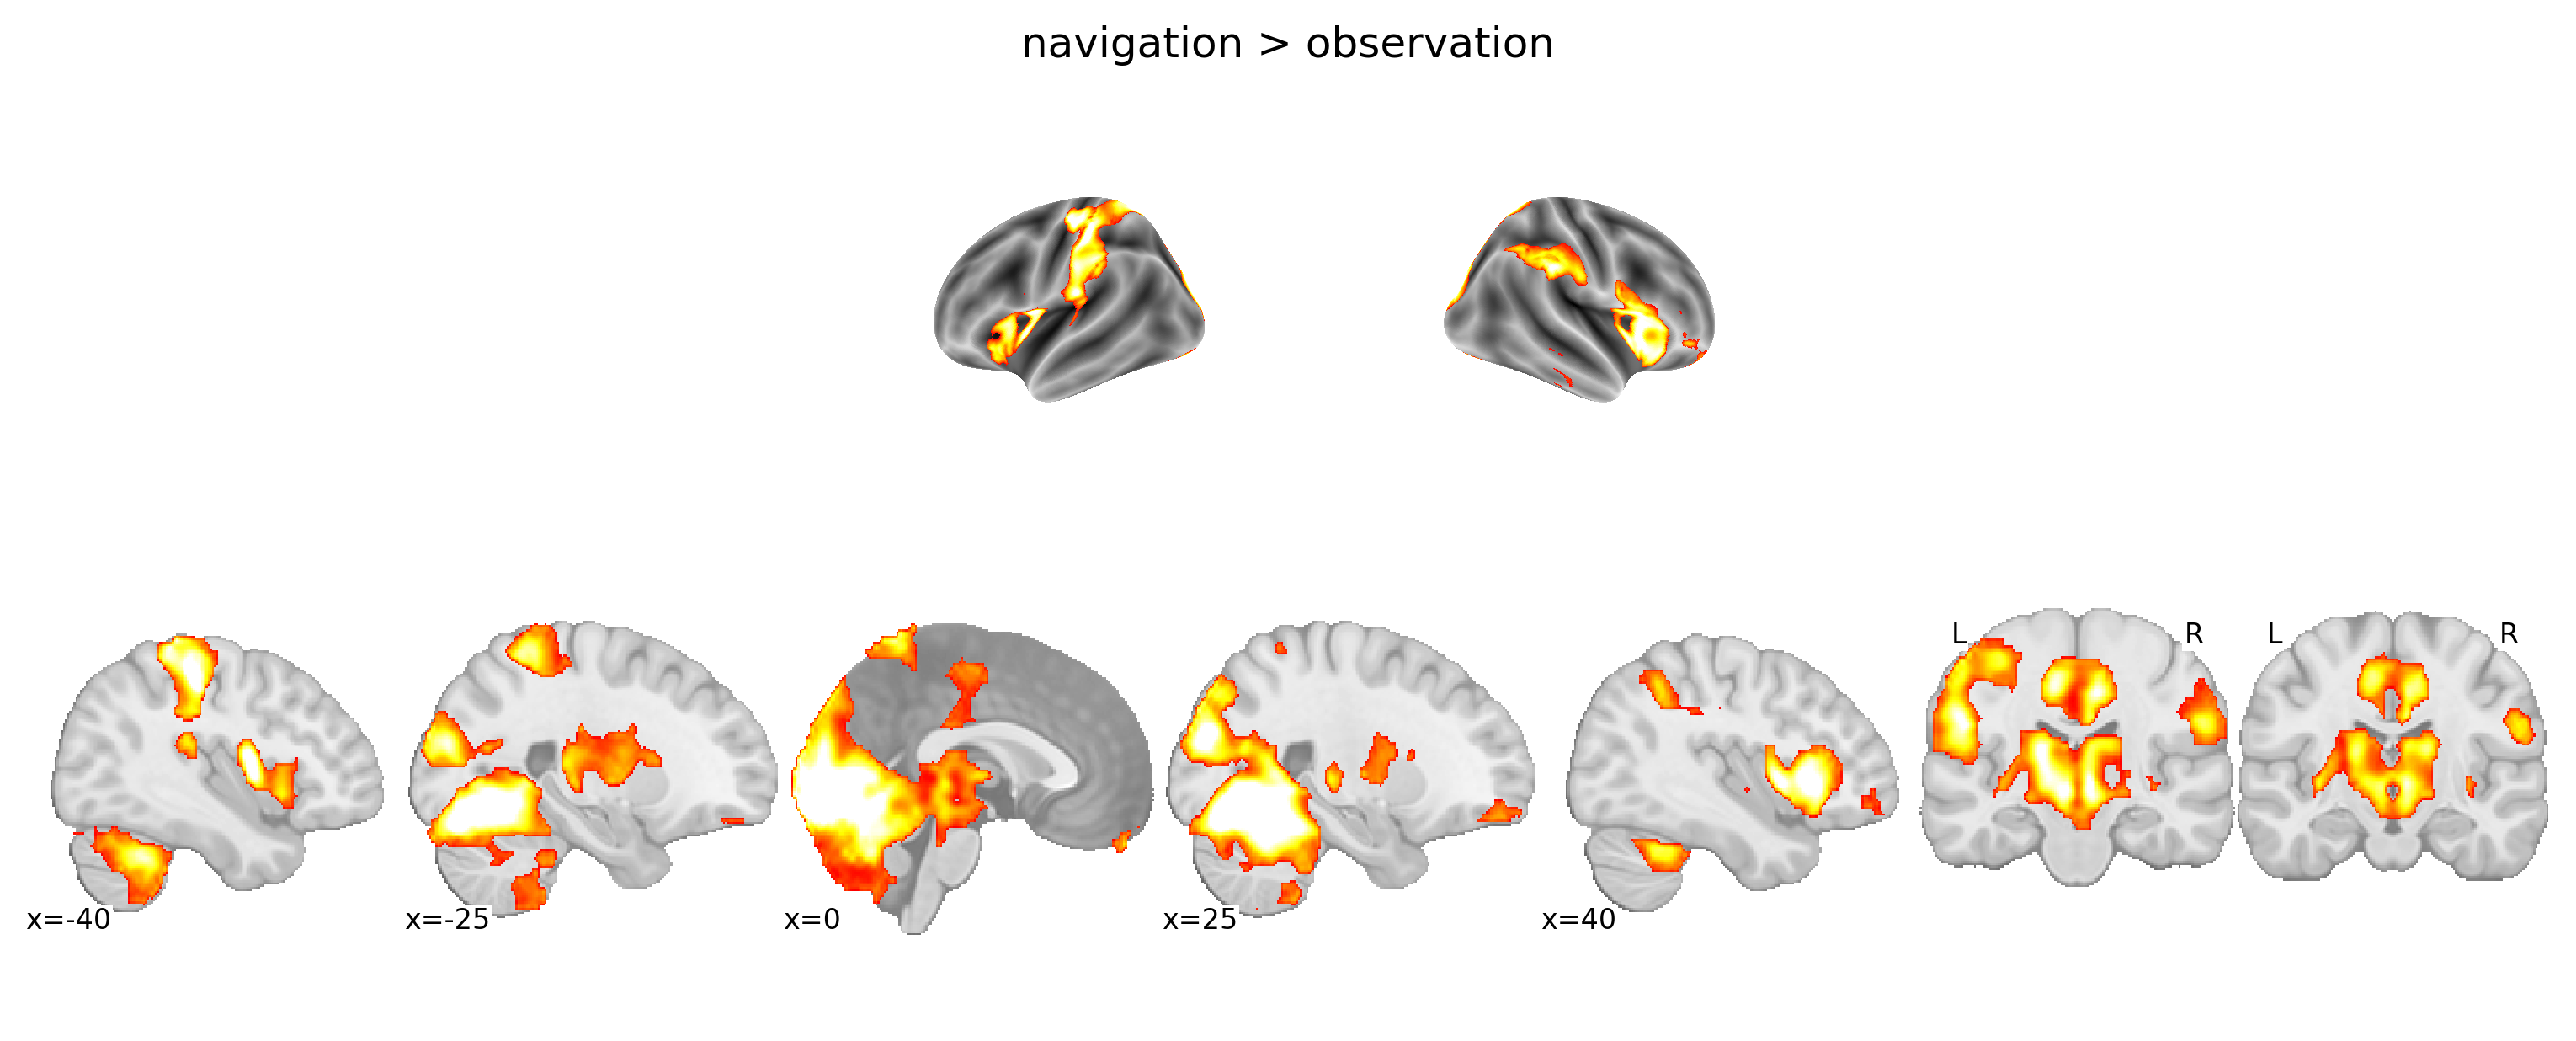

In [44]:
fig = plt.figure(figsize=(10, 4), dpi=300)
#  rc('font', size=8)

plot_upper_l = fig.add_subplot(2, 4, 2, projection="3d")

plotting.plot_surf_stat_map(
    big_fsaverage.infl_left,
    big_texture_l,
    hemi="left",
    view="lateral",
    colorbar=False,
    threshold=threshold,
    bg_map=big_fsaverage.sulc_left,
    vmax=10,
    figure=fig,
    axes=plot_upper_l,
)


plot_upper_r = fig.add_subplot(2, 4, 3, projection="3d")
plotting.plot_surf_stat_map(
    big_fsaverage.infl_right,
    big_texture_r,
    hemi="right",
    view="lateral",
    colorbar=False,
    threshold=threshold,
    bg_map=big_fsaverage.sulc_right,
    vmax=10,
    figure=fig,
    axes=plot_upper_r,
)


plot_left = plotting.plot_stat_map(
    thresholded_map_pos,
    bg_img=template,
    cut_coords=(-40, -25, 0, 25, 40),
    display_mode="x",
    threshold=threshold,
    vmax=10,
    black_bg=False,
    colorbar=False,
    annotate=False,
    figure=fig,
    axes=(0, 0, 0.75, 0.48),  # axes = (xmin, ymin, width, height)
)

plot_left.annotate(left_right=False, positions=True, size=8, scale_loc="center")

plot_right = plotting.plot_stat_map(
    thresholded_map_pos,
    bg_img=template,
    cut_coords=(-20, -15),
    display_mode="y",
    threshold=threshold,
    vmax=10,
    black_bg=False,
    colorbar=False,
    annotate=False,
    figure=fig,
    axes=(0.75, 0, 0.25, 0.48),
)

plot_right.annotate(left_right=True, positions=False, size=8, scale_loc="center")

fig.suptitle(chosen_contrast)

fig.savefig("multiplot_figure.png")

## **C)** Glass brain plot for contrast `obervation > baseline * cumulative distance error (vm)`

### Define data and distance matrix

In [45]:
chosen_contrast = "obervation > baseline * cumulative distance error (vm)"


cmaps_dir = (
    data_dir
    + "/model_m1_contrasts_swratopup/"
    + contrast_dir_dict[chosen_contrast]
    + "-AllSessions"
)

print(f"data is stored in: {abspath(cmaps_dir)}")

cmaps = sorted(
    glob(
        f"{abspath(cmaps_dir)}/**/*.nii",
        recursive=True,
    )
)

# pprint(cmaps)
print(f"\nThere are {len(cmaps)} contrast maps")

n_subjects = len(cmaps)
subject_list = [f"sub-{i:02d}" for i in range(1, n_subjects + 1)]

data is stored in: /main/assignments/group/data_Wagner_NatComms_2022/model_m1_contrasts_swratopup/other-AllSessions

There are 59 contrast maps


In [46]:
# Intercept-only model, no groups, no 2nd level contrasts
design_matrix = pd.DataFrame(
    [1] * n_subjects, columns=["intercept"], index=subject_list
)

dist_err = pd.read_excel("data_Wagner_NatComms_2022/avgDistErr_20210408.xlsx")
dist_err["subjn"] = "sub-" + dist_err["subjn"].astype(str).str.zfill(2)
dist_err = dist_err.set_index("subjn")

design_matrix = design_matrix.merge(
    dist_err["mean"], left_index=True, right_index=True
).rename(columns={"mean": "distance_error"})

design_matrix.head()

,intercept,distance_error
sub-01,1,19.41951
sub-02,1,26.60407
sub-03,1,10.69242
sub-04,1,27.78675
sub-05,1,14.30383


<div class="alert alert-warning">How to correctly specify the interaction?</div>

The FDR=.001 threshold is 3.919


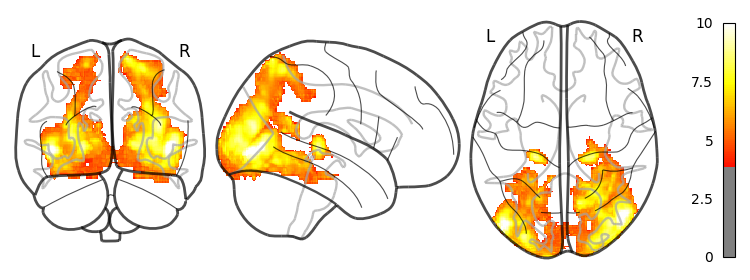

In [47]:
# Filter filepaths of cmaps to available data

import re


def check_available(filepath, mat):
    number = re.findall("S[0-9][0-9]_", filepath)[0].replace("S", "").replace("_", "")
    res = "sub-" + number
    res = res in mat.index
    return res


cmaps_filtered = [cm for cm in cmaps if check_available(cm, design_matrix)]

second_level = SecondLevelModel(n_jobs=2)
second_level = second_level.fit(cmaps_filtered, design_matrix=design_matrix)

other_baseline = second_level.compute_contrast(
    second_level_contrast="intercept + distance_error",
    output_type="stat",
    second_level_stat_type="t",
)

thresholded_map, threshold = threshold_stats_img(
    other_baseline,
    alpha=0.001,
    height_control="fdr",
    cluster_threshold=80,
    two_sided=True,
)

print(f"The FDR=.001 threshold is {round(threshold, 3)}")


thresholded_map_pos = image.new_img_like(
    thresholded_map, np.clip(thresholded_map.get_fdata(), 0, None)
)

# scale up resolution to template
thresholded_map_pos = resample_to_img(thresholded_map_pos, template)


plotting.plot_glass_brain(
    thresholded_map_pos, threshold=threshold, colorbar=True, vmax=10, cmap="cold_hot"
)

# 2. Store objects

Save

In [48]:
import pickle

pickle.dump(second_level, open("second_level.pkl", "wb"))
!ls ./

'Group assignment.ipynb'     multiplot_figure.png	    second_level.pkl
 data_Wagner_NatComms_2022   multiplot_figure_obs_nav.png


Load

In [49]:
secondlvl_pkl = pickle.load(open("second_level.pkl", "rb"))

secondlvl_pkl.design_matrix_.head()

,intercept,distance_error
sub-01,1,19.41951
sub-02,1,26.60407
sub-03,1,10.69242
sub-04,1,27.78675
sub-05,1,14.30383


As we have pickled the already fitted object, we can go ahead and evaluate some contrasts (without fitting the model again):

/usr/local/lib/python3.10/dist-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


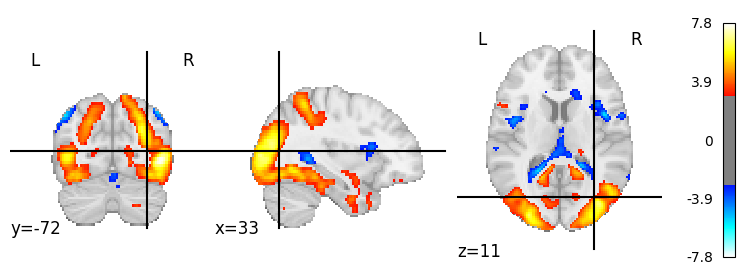

In [50]:
other_self_pkl = secondlvl_pkl.compute_contrast(
    second_level_contrast="intercept", output_type="z_score"
)

plotting.plot_stat_map(other_self_pkl, threshold=3)

# 3. ROI Analysis

aka **confirmatory analysis**. This can allow for more powerful statistical inference.

We nned a mask of our ROI (i.e., information which voxels are to be included in the analysis)

<div class="alert alert-warning">Below code is an example. We still need to swap the data and choose our own ROI.</div>

### Where to get ROI masks from?

#### Atlas-based masks

One option you have is to use an **atlas**: An atlas is map that divides the brain into anatomically distinct regions (this is also called *parcellation*. 

There are different atlasses you can use. In fact, Nilearn currently ships with 18 atlasses - see [here](https://nilearn.github.io/stable/modules/datasets.html#atlases). One commonly used atlas is the [Harvard-Oxford atlas](https://scalablebrainatlas.incf.org/human/HOA06) that comes with FSL. Let's have a look:

In [57]:
from pprint import pprint
from nilearn import datasets, plotting, image

atlas = datasets.fetch_atlas_harvard_oxford("cort-prob-2mm")
print(f"This atlas includes {len(atlas.labels) - 1} regions")
print(f"Shape of the atlas: {atlas.maps.shape}")
print(f"The atlas image is located at: {atlas.filename}")


Dataset created in /root/nilearn_data/fsl



Downloaded 6963200 of 25716861 bytes (27.1%,    2.7s remaining) ...done. (3 seconds, 0 min)
Extracting data from /root/nilearn_data/fsl/f627ac501ac9e24b781981dbe4f4f56f/HarvardOxford.tgz...

This atlas includes 48 regions
Shape of the atlas: (91, 109, 91, 48)
The atlas image is located at: /root/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-prob-2mm.nii.gz


.. done.


Great! We have loaded the atlas (a single ```.nii.gz``` file) and know that it includes 48 regions (we subtract 1 because the background is included as a region) - stored in the 4th dimension of the nifti file. 

The atlas also comes with anatomical labels of these regions:

In [58]:
pprint(atlas.labels)

['Background',
 'Frontal Pole',
 'Insular Cortex',
 'Superior Frontal Gyrus',
 'Middle Frontal Gyrus',
 'Inferior Frontal Gyrus, pars triangularis',
 'Inferior Frontal Gyrus, pars opercularis',
 'Precentral Gyrus',
 'Temporal Pole',
 'Superior Temporal Gyrus, anterior division',
 'Superior Temporal Gyrus, posterior division',
 'Middle Temporal Gyrus, anterior division',
 'Middle Temporal Gyrus, posterior division',
 'Middle Temporal Gyrus, temporooccipital part',
 'Inferior Temporal Gyrus, anterior division',
 'Inferior Temporal Gyrus, posterior division',
 'Inferior Temporal Gyrus, temporooccipital part',
 'Postcentral Gyrus',
 'Superior Parietal Lobule',
 'Supramarginal Gyrus, anterior division',
 'Supramarginal Gyrus, posterior division',
 'Angular Gyrus',
 'Lateral Occipital Cortex, superior division',
 'Lateral Occipital Cortex, inferior division',
 'Intracalcarine Cortex',
 'Frontal Medial Cortex',
 'Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)',
 'Subcallo

Let's plot the whole atlas: 

/usr/local/lib/python3.10/dist-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


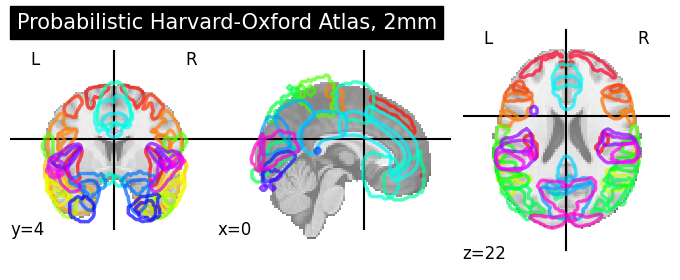

In [59]:
plotting.plot_prob_atlas(atlas.maps, title="Probabilistic Harvard-Oxford Atlas, 2mm")

We can also access the individual regions using the ```index_img``` function from Nilearn's ```image``` module. Let's have a look at the Angular Gyrus and the Temporal Pole (exluding the background, thus we need to subtract 1 to get the correct index):

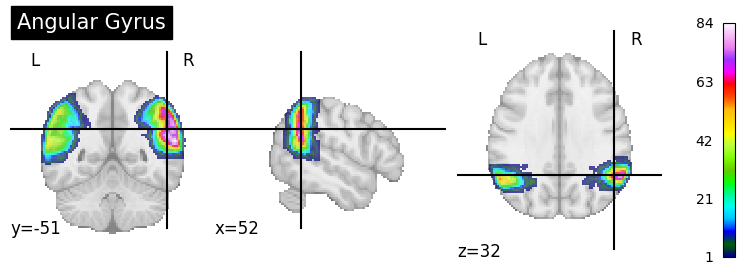

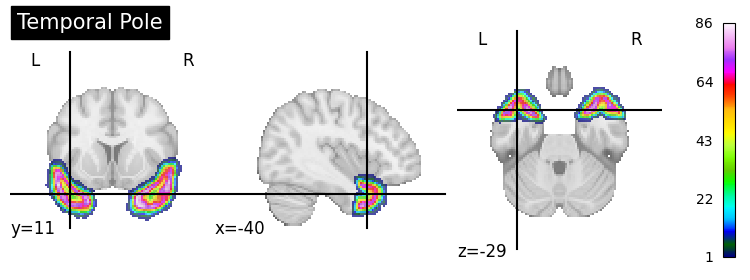

In [60]:
for roi in ["Angular Gyrus", "Temporal Pole"]:
    roi_idx = atlas.labels.index(roi) - 1
    roi_mask = image.index_img(atlas.maps, index=roi_idx)
    plotting.plot_roi(roi_mask, title=roi, colorbar=True)

As you can see the regions are plotting in different color (other than the whole-brain mask at the beginning of this notebook). This is because we are dealing with a **probabilistic** atlas which accounts for anatomical variablity within a population of different humans (i.e., voxels with high numbers represent that region in almost every participant).

If we want to have a ROI with only 0s and 1s (an **deterministic** ROI) we need to binarize the mask first, providing a threshold for which voxels are included or excluded. We can do this easily with Nilearn's ```binarize_img``` function:

/usr/local/lib/python3.10/dist-packages/nilearn/image/image.py:1041: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


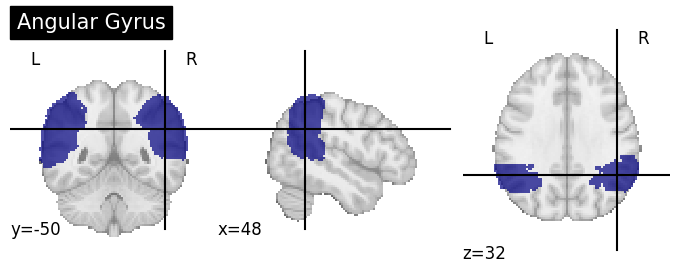

In [61]:
roi_idx = atlas.labels.index("Angular Gyrus") - 1
roi_mask = image.index_img(atlas.maps, roi_idx)
roi_mask_binarized = image.binarize_img(roi_mask, threshold="10%")

plotting.plot_roi(roi_mask_binarized, title="Angular Gyrus")

Here, we set a threshold of 10%. However, there is no standard threshold, so it's up to you to decide how much of the region you want to keep. If you set no threshold, you will get everything of that region but also bits of other structures as well. As always, this decision depends on the research question at hand.

Now we know how to create masks using atlas. There are other ways to get a mask, though. Let's have a look.

#### Pre-defined masks

Another way to perform a ROI-analysis is to do it based on a pre-defined mask. That is, using a .nii file that contains the info regarding which voxels make up that region. We could for example save that mask we created above and it use it again in another project. Or, your colleague might share a mask file that you could use in your analysis. Another possibility is to obtain a mask from online repositories, such as www.neurovault.org. 

Let's try that and download a VMPFC mask from neurovault using the GNU/Linux command ```wget```:

In [62]:
!wget https://neurovault.org/media/images/3462/VMPFC_mask_neurosynth_liberal.nii.gz

--2022-12-23 18:00:27--  https://neurovault.org/media/images/3462/VMPFC_mask_neurosynth_liberal.nii.gz
Resolving neurovault.org (neurovault.org)... 54.149.190.168
Connecting to neurovault.org (neurovault.org)|54.149.190.168|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35065 (34K) [application/octet-stream]
Saving to: ‘VMPFC_mask_neurosynth_liberal.nii.gz’

VMPFC_mask_neurosyn 100%[===================>]  34.24K  --.-KB/s    in 0.004s  

2022-12-23 18:00:28 (9.24 MB/s) - ‘VMPFC_mask_neurosynth_liberal.nii.gz’ saved [35065/35065]



In [64]:
import nibabel as nib

vmpfc_mask = nib.load("VMPFC_mask_neurosynth_liberal.nii.gz")
print(f"shape of the mask: {vmpfc_mask.shape}")

shape of the mask: (91, 109, 91)


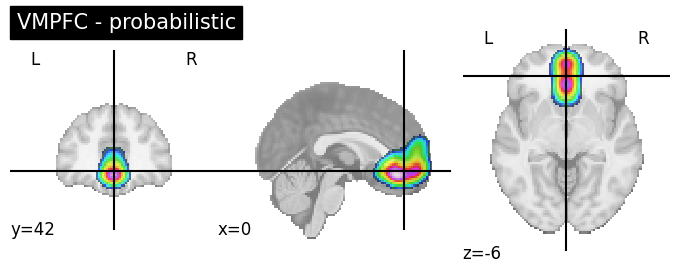

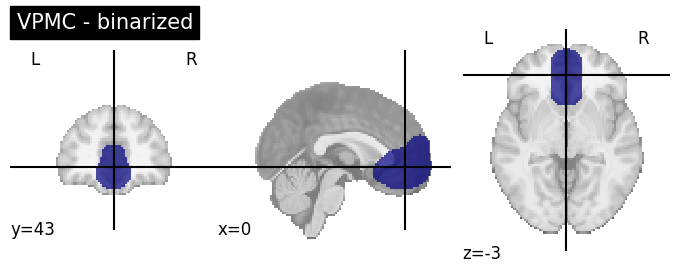

In [65]:
plotting.plot_roi(vmpfc_mask, title="VMPFC - probabilistic")
plotting.plot_roi(image.binarize_img(vmpfc_mask, "10%"), title="VPMC - binarized")

#### Spherical masks

So far, we have dealt with anatomical masks. Another way is to use **spherical ROIs**. Here, we provide x-, y-, z-coordinates (oftentimes obtained from peak activations reported in other studies) and a radius in mm. The result is a sphere around that center coordinates.

In Python, we can create our own spherical mask using the ```nltools``` package:

Let's recreate the mask of the dorsal anterior cingulate cortex used in Rütgen et al. (2015):

/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:274: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "


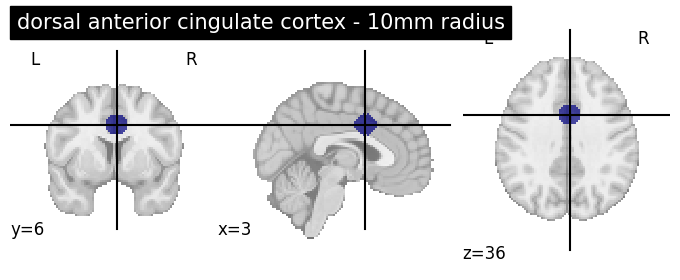

In [67]:
from nltools.mask import create_sphere

# mni coordinates
dacc_coords = (3, 6, 36)
dacc_sphere = create_sphere(dacc_coords, radius=10)

plotting.plot_roi(dacc_sphere, title="dorsal anterior cingulate cortex - 10mm radius")

We can save the created sphere using Nibabel's ```save``` function (this holds for the other mask creation approaches as well):

In [68]:
nib.save(dacc_sphere, "dacc_sphere.nii")

### Implementation in Nilearn

Maskers are a central concept in Nilearn. Basically, it allows one to transform 3D/4D MRI/fMRI data to a 2D matrix (where samples x features). Most of the time, samples are timepoints in an fMRI experiment whereas features relate to different regions of interest. 

That is, transforming the data so that we get a matrix with signal time-series for our regions of interest. This is in important concept for the analysis of functional connectivity (e.g. during resting state)

You can find a comprehensive overview on Nilearn masker objects in the official [user guide](https://nilearn.github.io/dev/manipulating_images/masker_objects.html)

#### Extract ROI data from contrast maps

For now, we will concentrate on how to extract contrast values for given ROIs. That is, for a certain number of participants we want to obtain the mean contrast value in a specific ROI.

To return to the example from last weeks, let's consider the Right vs. left button press task and get an estimate of the mean activation in the left motor cortex (because we know from theory that we should find activation here) and compare it to the right motor cortex. First, let's download the data:

<div class="alert alert-warning">Download does not always seem to work.</div>

In [ ]:
n_subjects = 20

con_right_left = datasets.fetch_localizer_contrasts(
    ["right vs left button press"], n_subjects
)

Next, we need masks of the left and right precentral gyri, respectively. Since we are now interested in lateralized regions, we need to get a lateralized version of the atlas:

In [72]:
atlas_lateralized = datasets.fetch_atlas_harvard_oxford(
    "cortl-prob-2mm"
)  # cortl = cortical lateralized

We'll also create a short helper function to select specific regions:

In [73]:
def get_roi(atlas, roi_label, thresh):
    """Extracts ROI mask from atlas based on verbal label"""

    roi_idx = atlas.labels.index(roi_label) - 1
    roi_mask = image.index_img(atlas.maps, roi_idx)
    roi_mask_bin = image.binarize_img(roi_mask, threshold=thresh)

    return roi_mask_bin

/usr/local/lib/python3.10/dist-packages/nilearn/image/image.py:1041: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


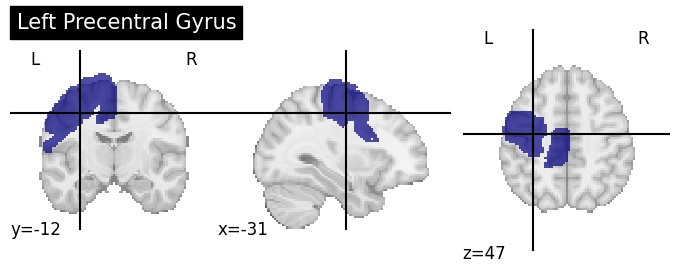

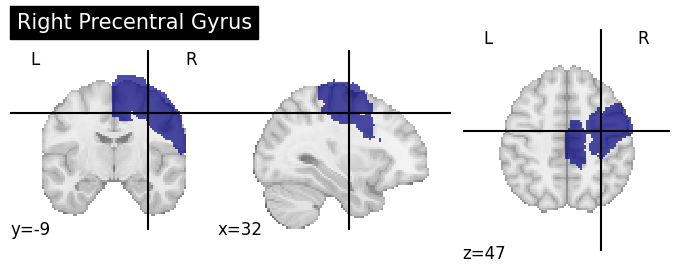

In [74]:
rois = ["Left Precentral Gyrus", "Right Precentral Gyrus"]

for roi in rois:
    roi_mask = get_roi(atlas_lateralized, roi, "10%")
    plotting.plot_roi(roi_mask, title=roi)

##### NiftiLabelsMasker
Great, the function works as expected. Now we can go ahead and actually extract some estimates. For this we will use Nilearn's [```NiftiLabelsMasker```](https://nilearn.github.io/stable/modules/generated/nilearn.maskers.NiftiLabelsMasker.html). We will start by doing it for one region and one participant. First, we generate a mask and then we instantiate the masker object (this works the same way as setting up the first and second level models in Nilearn):

In [75]:
from nilearn.maskers import NiftiLabelsMasker

# get contrast map of first subject
test_subj = con_right_left.cmaps[0]

# get roi mask
left_precentral_gyrus = get_roi(atlas_lateralized, "Left Precentral Gyrus", "10%")

# instantiate masker object
masker = NiftiLabelsMasker(left_precentral_gyrus)

Once the masker object has been instantiated, we can extraced the contrast estimate from the contrast map using the ```fit_transform``` method and providing the data of our subject:

In [76]:
left_precentral_mean = masker.fit_transform(test_subj)
print(f"Mean contrast estimate in the left precentral gyrus: {left_precentral_mean}")

Mean contrast estimate in the left precentral gyrus: [[2.0042236]]


/usr/local/lib/python3.10/dist-packages/nilearn/_utils/niimg.py:63: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


This value we got is the contrast estimate averaged across all voxels included in the mask.


#### NiftiSpheresMasker

Now, one could argue that the mask we provided was a broad and includes regions other than the M1. One possibility to be more specific would be to use a spherical mask. For this we could either create our own sphere using ```nltools``` (as done above) or use the Nilearn function ```NiftiSpheresMasker```. The MNI coordinates for the left and right M1 are adapted from Zhang et al. (2016).

/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:274: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "
/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:274: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "


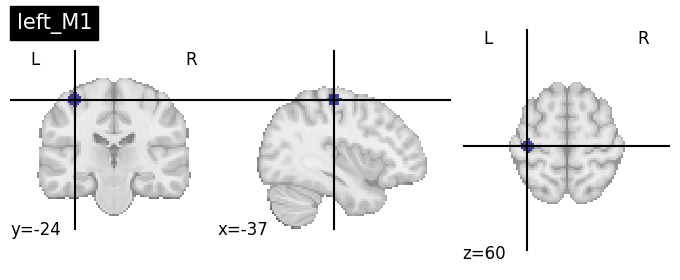

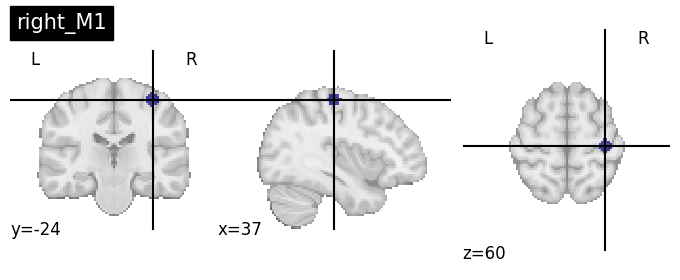

In [77]:
m1_coords = {"left_M1": (-37, -24, 60), "right_M1": (37, -24, 60)}

# quickly plot the masks before moving on
for label, coords in m1_coords.items():
    mask = create_sphere(coords, radius=6)
    plotting.plot_roi(mask, title=label)

Looks good! Now let's extract some contrast estimates. This time, however, we will not only use [```NiftiSpheresMasker```](https://nilearn.github.io/stable/modules/generated/nilearn.maskers.NiftiSpheresMasker.html) but also applying to all subjects and both regions. To make our lifes easier (and our approach more reproducible), we will create a function for this

In [78]:
from nilearn.maskers import NiftiSpheresMasker
import numpy as np


def extract_roi_sphere(cmaps, coords, radius):
    """extract mean roi activation from contrast map

    Input:
    - List of contract maps
    - MNI coordinates
    - Sphere radius in mm

    """

    # instantiate numpy array to store results
    out = np.zeros(len(cmaps))

    # setup masker
    masker = NiftiSpheresMasker([coords], radius=radius)

    # loop over subjects
    for i, cmap in enumerate(cmaps):
        print(f"processing subject {i+1}")
        out[i] = masker.fit_transform(cmap)
        print("done\n")

    return out

In [79]:
# turn of nilearn warnings regarding NaN values
import warnings

warnings.simplefilter("ignore", UserWarning)

In [80]:
left_m1_means = extract_roi_sphere(con_right_left.cmaps, m1_coords["left_M1"], radius=6)

right_m1_means = extract_roi_sphere(
    con_right_left.cmaps, m1_coords["right_M1"], radius=6
)

processing subject 1
done

processing subject 2
done

processing subject 3
done

processing subject 4
done

processing subject 5
done

processing subject 6
done

processing subject 7
done

processing subject 8
done

processing subject 9
done

processing subject 10
done

processing subject 11
done

processing subject 12
done

processing subject 13
done

processing subject 14
done

processing subject 15
done

processing subject 16
done

processing subject 17
done

processing subject 18
done

processing subject 19
done

processing subject 20
done

processing subject 1
done

processing subject 2
done

processing subject 3
done

processing subject 4
done

processing subject 5
done

processing subject 6
done

processing subject 7
done

processing subject 8
done

processing subject 9
done

processing subject 10
done

processing subject 11
done

processing subject 12
done

processing subject 13
done

processing subject 14
done

processing subject 15
done

processing subject 16
done

processing

In [81]:
pprint(left_m1_means)
pprint(right_m1_means)

array([10.65760136, 12.14851189,  6.23771858,  7.66447115, 12.28662491,
        8.43939304,  0.07467647,  6.90532923, 14.52539825,  7.26462555,
        4.65700722, 10.69576073,  9.06713676,  6.03446579, 17.13100815,
       13.29641533, 11.58852863,  9.50289249, 12.82460976, 10.60359383])
array([-10.09011078, -16.67847061, -18.08119965, -21.96448135,
        -9.22185135,  -8.20207024,  -9.87050724,  -3.47193384,
        -9.05239677,  -3.37096357,  -8.76615334,  -6.95248699,
        -4.67750597, -17.13501167, -21.65268898, -12.54200363,
       -19.44042969, -10.45025444,  -6.88386059, -10.21671581])


## References & Resources

Rütgen, M., Seidel, E. M., Silani, G., Riečanský, I., Hummer, A., Windischberger, C., ... & Lamm, C. (2015). Placebo analgesia and its opioidergic regulation suggest that empathy for pain is grounded in self pain. Proceedings of the National Academy of Sciences, 112(41), E5638-E5646.

Zhang, Y., Liu, H., Wang, L., Yang, J., Yan, R., Zhang, J., ... & Qiu, M. (2016). Relationship between functional connectivity and motor function assessment in stroke patients with hemiplegia: a resting-state functional MRI study. Neuroradiology, 58(5), 503-511.

Analogous example for ROI analysis in SPM: http://andysbrainblog.blogspot.com/2014/07/quick-and-efficient-roi-analysis-using.html